Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4319 seconds.


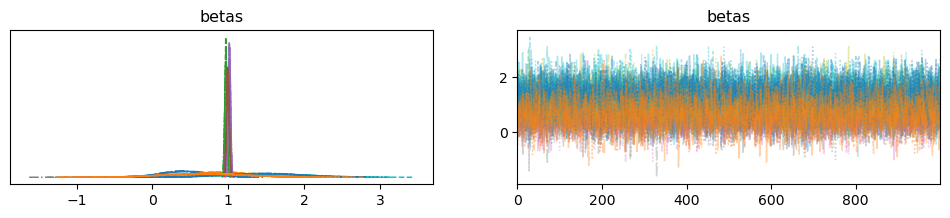

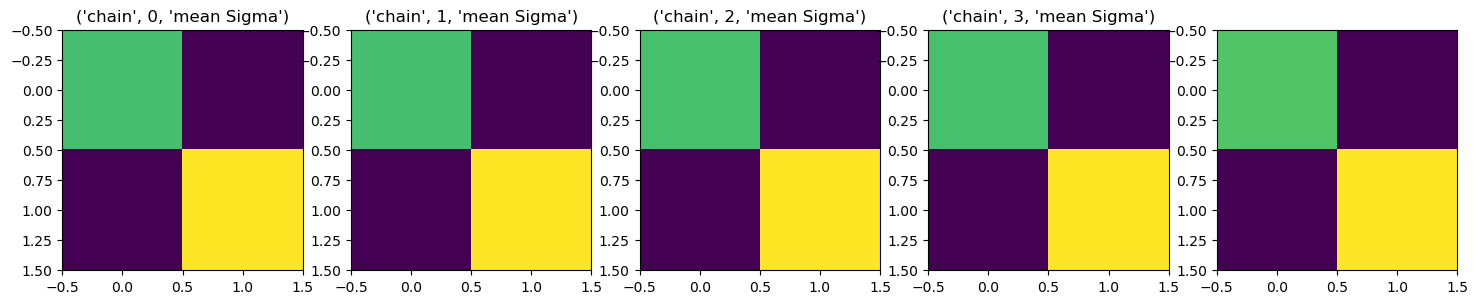

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("diamonds.csv")

# Downsample the dataset for efficient computation
df_sample = df.sample(n=100, random_state=42)

features = ["carat", "depth", "table", "x", "y", "z"]
target = "price"

# Prepare data matrices
X = df_sample[features].values
y = df_sample[target].values.reshape(-1, 1)

# Define problem dimensions
n, p = X.shape  # (samples, number of predictors)
m = 2  # Set m > 1 to avoid matrix errors

# Generate prior covariance matrix for multivariate normal
beta = np.ones((p, m))
a_cov = stats.invwishart(df=m + 2, scale=np.eye(m)).rvs()
x_beta = X @ beta + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))
    y_obs = pm.MvNormal("y", mu=X @ betas, chol=L, observed=x_beta)

    # Sample posterior
    idata = pm.sample()

# Trace plot
az.plot_trace(idata, var_names="betas")
plt.show()

# Posterior covariance visualization
fig, ax = plt.subplots(1, 5, figsize=(18, 4))
ax[-1].imshow(a_cov)
ax[0].set_title("Sigma used to generate y")

for chain in range(4):
    ax[chain].imshow(idata.posterior["Sigma"].mean(axis=1)[chain])
    ax[chain].set_title(("chain", chain, "mean Sigma"))

plt.show()